In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

In [6]:
# load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# clean the dataset and encode labels
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [9]:
# split data and convert to numpy array
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], 
    df['label_enc'],
    test_size=0.2,
    random_state=42)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [10]:
avg_words_len = round(sum([len(i.split())
                           for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(' '.join(df['Text']).split()))

print(f'Data Loaded.  Training samples: {len(X_train_np)}')
print(f'Average words per message: {avg_words_len}')
print(f'Approximate vocabulary size: {total_words_length}')

Data Loaded.  Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


In [12]:
# helper functions for training and evaluation
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    history = model.fit(X_train_np, y_train_np, epochs=epochs, validation_data=(X_test_np, y_test_np))
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
    'accuracy': accuracy_score(y, y_preds),
    'precision': precision_score(y, y_preds),
    'recall': recall_score(y, y_preds),
    'f1-score': f1_score(y, y_preds)}

In [14]:
# TextVectorization layer to convert raw text into interger sequences
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)
text_vec.adapt(X_train_np)

In [16]:
# dense embedding model
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name='Dense_Model')
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9076 - loss: 0.2640 - val_accuracy: 0.9614 - val_loss: 0.1383
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9791 - loss: 0.0818 - val_accuracy: 0.9776 - val_loss: 0.0753
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9910 - loss: 0.0367 - val_accuracy: 0.9776 - val_loss: 0.0697
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9946 - loss: 0.0215 - val_accuracy: 0.9758 - val_loss: 0.0662
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.0147 - val_accuracy: 0.9758 - val_loss: 0.0726


In [17]:
# bidirectional LSTM model
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name='BiLSTM_Model')
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9468 - loss: 0.1633 - val_accuracy: 0.9767 - val_loss: 0.0847
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9908 - loss: 0.0370 - val_accuracy: 0.9713 - val_loss: 0.0955
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9957 - loss: 0.0118 - val_accuracy: 0.9731 - val_loss: 0.0852
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9980 - loss: 0.0065 - val_accuracy: 0.9767 - val_loss: 0.1015
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9991 - loss: 0.0021 - val_accuracy: 0.9767 - val_loss: 0.1351


In [18]:
# transfer learning with universal sentence encoder
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name='USE_Model')
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9181 - loss: 0.3064 - val_accuracy: 0.9686 - val_loss: 0.1152
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9789 - loss: 0.0849 - val_accuracy: 0.9785 - val_loss: 0.0718
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9836 - loss: 0.0571 - val_accuracy: 0.9812 - val_loss: 0.0612
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9879 - loss: 0.0454 - val_accuracy: 0.9812 - val_loss: 0.0564
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9888 - loss: 0.0383 - val_accuracy: 0.9839 - val_loss: 0.0531


In [20]:
# collect perfomance metrics for all models
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np), 
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print('Performance Table: ')
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Performance Table: 
                         accuracy  precision    recall  f1-score
Dense Embedding          0.975785   0.923611  0.892617  0.907850
Bi-LSTM                  0.976682   0.930070  0.892617  0.910959
Transfer Learning (USE)  0.983857   0.951724  0.926174  0.938776


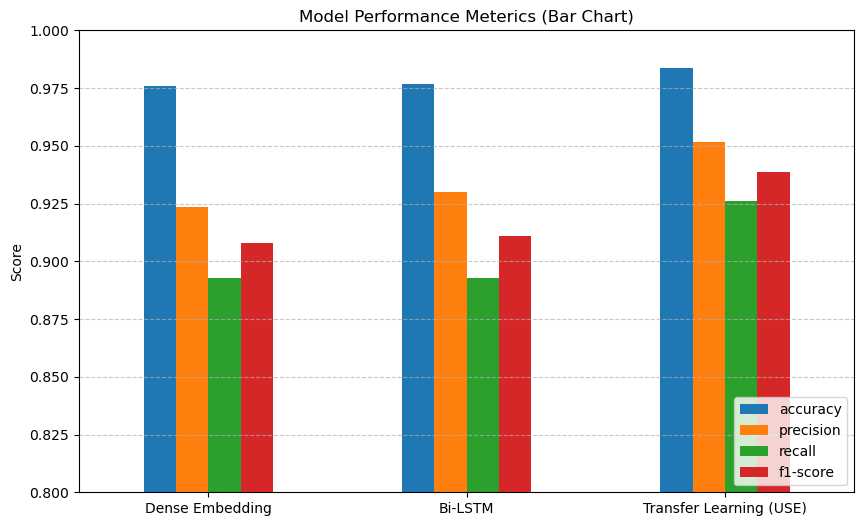

In [25]:
# visualize: bar
results_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Meterics (Bar Chart)')
plt.ylabel('Score')
plt.ylim([0.8, 1.0])
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

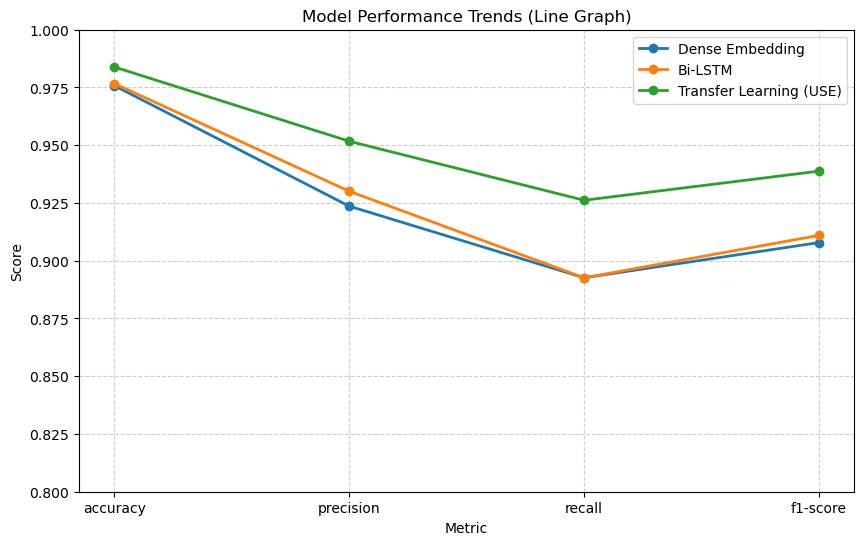

In [26]:
# visualize: line
plt.figure(figsize=(10, 6))
for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2)

plt.title('Model Performance Trends (Line Graph)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim([0.8, 1.0])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()